In [ ]:
import warnings

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import segmentation_models as sm
import albumentations as A

from PIL import Image
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

warnings.filterwarnings('ignore')

Segmentation Models: using `tf.keras` framework.


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
image_directory = '/kaggle/input/dl-oct2024/Unet_Dataset/glioma_img/'
mask_directory = '/kaggle/input/dl-oct2024/Unet_Dataset/glioma_mask/'

In [4]:
SIZE = 128

img_dataset = []
mask_dataset = []

images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

for i, image_name in enumerate(images):
    if '(1)' in image_name:
        continue
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + image_name)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        img_dataset.append(np.array(image))

for i, mask_name in enumerate(masks):
    if '(1)' in mask_name:
        continue
    if image_name.endswith('.jpg'):
        image = cv2.imread(os.path.join(mask_directory, mask_name), 
                           cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        # Convert to binary (thresholding)
        _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        # Normalize to 0 and 1
        binary_image = (binary_image / 255).astype(np.uint8)
        binary_image = Image.fromarray(binary_image)
        binary_image = binary_image.resize((SIZE, SIZE))

        mask_dataset.append(np.array(binary_image))

In [5]:
img_dataset = np.array(img_dataset, dtype=np.float32) / 255.0
mask_dataset = np.array(mask_dataset, dtype=np.float32)

In [6]:
len(img_dataset), len(mask_dataset)

(1141, 1141)

In [7]:
np.unique(mask_dataset)

array([0., 1.], dtype=float32)

In [8]:
mask_dataset = np.expand_dims(a=mask_dataset, axis=-1)

In [9]:
img_dataset.shape, mask_dataset.shape

((1141, 128, 128, 3), (1141, 128, 128, 1))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_dataset, mask_dataset, 
                                                    test_size=0.25, 
                                                    shuffle=True, 
                                                    random_state=0)

In [11]:
len(X_train), len(y_train)

(855, 855)

In [12]:
len(X_test), len(y_test)

(286, 286)

In [13]:
backbone_architecture = 'resnet34'
preprocess_input = sm.get_preprocessing(backbone_architecture)

In [14]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [15]:
X_train.shape, y_train.shape

((855, 128, 128, 3), (855, 128, 128, 1))

In [16]:
augmentation = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    ToTensorV2()
])

In [17]:
augmented_images = [np.transpose(augmentation(image=(img * 255).astype(np.uint8))['image'], (1, 2, 0)) for img in X_train]
augmented_masks = [np.transpose(augmentation(image=(mask * 255).astype(np.uint8))['image'], (1, 2, 0)) for mask in y_train]

X_train_aug = np.array(augmented_images)
y_train_aug = np.array(augmented_masks)

In [18]:
X_train_aug.shape, y_train.shape

((855, 128, 128, 3), (855, 128, 128, 1))

In [19]:
model = sm.Unet(backbone_architecture, 
                input_shape=(SIZE, SIZE, 3), 
                encoder_weights='imagenet', 
                classes=1, 
                activation='sigmoid')

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

In [ ]:
@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    return (intersection + 1e-5) / (union + 1e-5)

In [ ]:
@tf.keras.utils.register_keras_serializable()
def bce_dice_loss(y_true, y_pred):
    # You can try combining Binary Crossentropy with Dice Loss (a common approach)
    bce = BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) + 1e-5
    dice = 1 - (2.0 * intersection + 1e-5) / union
    return bce + dice

In [ ]:
model.compile(optimizer=Adam(learning_rate=5e-3), 
              loss=bce_dice_loss, 
              metrics=[iou_metric])

In [ ]:
model_checkpoint = ModelCheckpoint(filepath='glioma_segmentation_resnet34_model.keras', 
                                   monitor='val_iou_metric', 
                                   mode='max', 
                                   verbose=1, 
                                   save_best_only=True)
early_stopping = EarlyStopping(monitor='val_iou_metric', 
                               mode='max', 
                               verbose=1, 
                               patience=10)

In [25]:
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    batch_size=64, 
                    callbacks=[model_checkpoint, 
                               early_stopping])

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - iou_metric: 0.1086 - loss: 0.9082 - val_iou_metric: 0.1042 - val_loss: 0.9243
Epoch 20/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - iou_metric: 0.1046 - loss: 0.9133
Epoch 20: val_iou_metric did not improve from 0.10416
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - iou_metric: 0.1047 - loss: 0.9131 - val_iou_metric: 0.0707 - val_loss: 1.0372
Epoch 21/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_metric: 0.1139 - loss: 0.8997
Epoch 21: val_iou_metric did not improve from 0.10416
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - iou_metric: 0.1137 - loss: 0.9001 - val_iou_metric: 0.1002 - val_loss: 0.9378
Epoch 22/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_metric: 0.1125 - loss: 0.9013
Epoch 22: val_iou_metric did not improve from 0.10416
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - iou_metric: 0.1123 - loss: 0.9016 - val_iou_metric: 0.0082 - val_loss: 1.1618
Epoch 23/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - iou_metric: 0.1143 - loss: 0.901

In [26]:
custom_objects = {
    'bce_dice_loss': bce_dice_loss,  # Ensure this function is defined
    'IOUScore': iou_metric
}

# Load model with custom objects
best_model = load_model('glioma_segmentation_resnet34_model.keras', custom_objects=custom_objects)

In [27]:
total_epochs = len(history.history['iou_metric'])

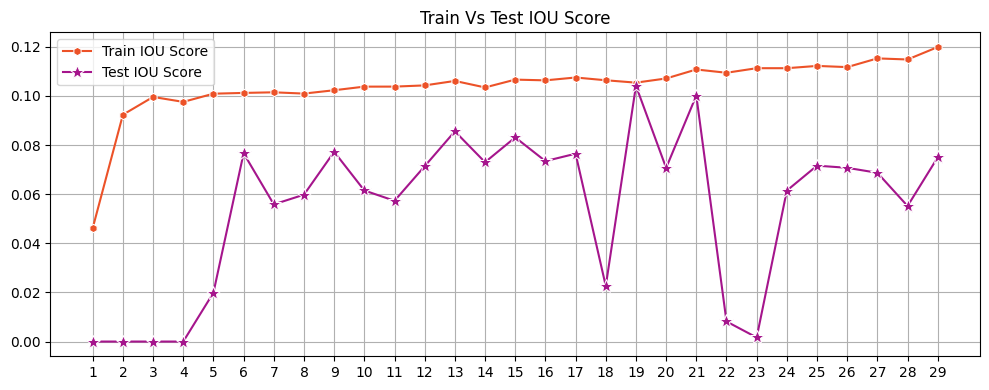

In [28]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['iou_metric'], 
             label='Train IOU Score', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_iou_metric'], 
             label='Test IOU Score', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test IOU Score")
plt.grid()
plt.tight_layout()
plt.show()

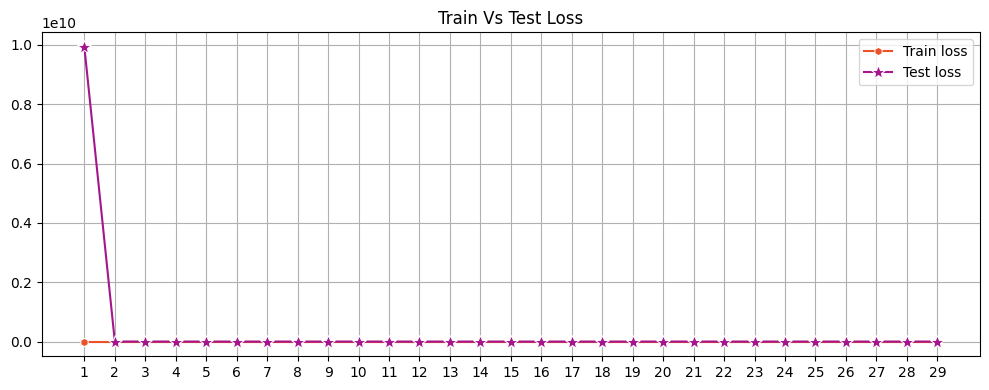

In [29]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['loss'], 
             label='Train loss', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_loss'], 
             label='Test loss', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [30]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - iou_metric: 0.1050 - loss: 0.9212
Test loss: 0.9242784976959229
Test accuracy: 0.10416167974472046


In [31]:
test_prediction = best_model.predict(X_test, verbose=1) 

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step


In [32]:
test_prediction_class = np.argmax(test_prediction, axis=1)

In [33]:
num_classes = 2
iou_metric = MeanIoU(num_classes=num_classes)
iou_metric.update_state(y_test, test_prediction > 0.5)
print("Mean IoU:", iou_metric.result().numpy())

Mean IoU: 0.5300393


In [34]:
image_index = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


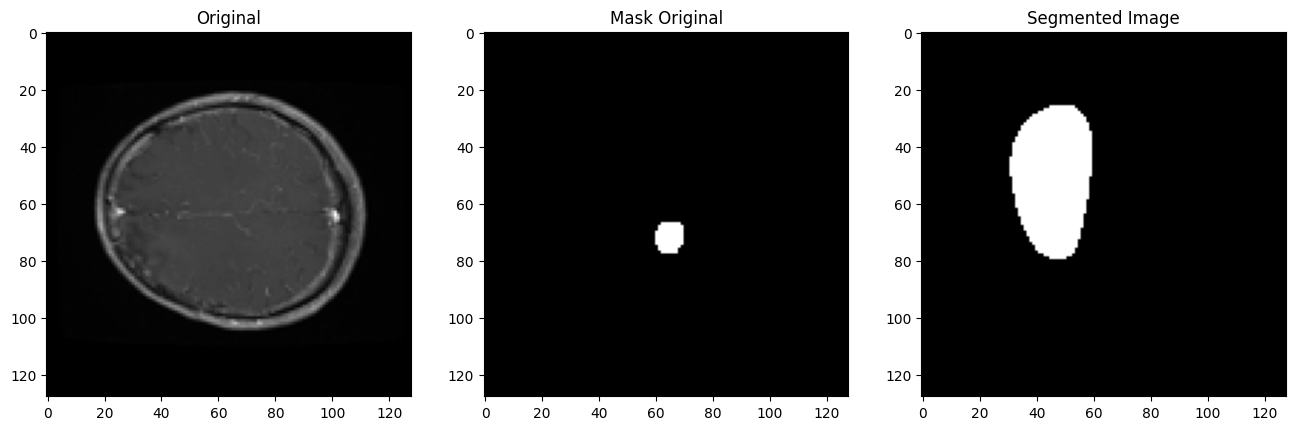

In [35]:
train_img = X_train[image_index]
train_img_exp = np.expand_dims(train_img, 0)
pred_img = model.predict(train_img_exp)
pred_img_exp = (pred_img[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(train_img[:,:,0],cmap='gray')

plt.subplot(132)
plt.title('Mask Original')
plt.imshow(y_train[image_index][:,:,0],cmap='gray')


plt.subplot(133)
plt.title('Segmented Image')
plt.imshow(pred_img_exp,cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


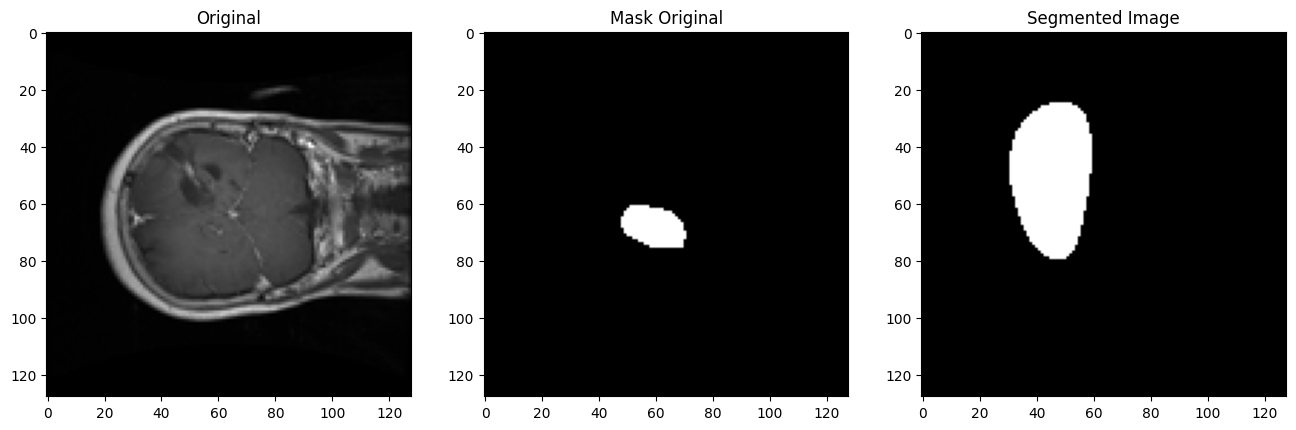

In [36]:
test_img = X_test[image_index]
test_img_exp = np.expand_dims(test_img, 0)
pred_img = model.predict(test_img_exp)
pred_img_bw = (pred_img[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(test_img[:,:,0],cmap='gray')

plt.subplot(132)
plt.title('Mask Original')
plt.imshow(y_test[image_index][:,:,0],cmap='gray')


plt.subplot(133)
plt.title('Segmented Image')
plt.imshow(pred_img_bw,cmap='gray')